In [5]:
import tensorflow as tf
from tensorflow.keras import layers , models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [6]:
data = pd.read_csv(r"D:\Downloads\archive (5)\pokemon.csv")
data

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [8]:
data.value_counts('Type1')

Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
dtype: int64

In [9]:
data = data[data.Type1.isin(['Water' , 'Grass' , 'Fire'])][['Name' , 'Type1']]
data

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire
...,...,...
778,bruxish,Water
786,tapu-bulu,Grass
787,tapu-fini,Water
797,kartana,Grass


In [10]:
print("Data shape", data.shape)
print("Number of unique elements" , data.Name.nunique)

Data shape (245, 2)
Number of unique elements <bound method IndexOpsMixin.nunique of 0        bulbasaur
1          ivysaur
2         venusaur
3       charmander
4       charmeleon
          ...     
778        bruxish
786      tapu-bulu
787      tapu-fini
797        kartana
805    blacephalon
Name: Name, Length: 245, dtype: object>


In [13]:
pip install opencv-python

   ---------------------------------------- 38.1/38.1 MB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import pandas as pd
import cv2
import numpy as np

image_df = []

# Use double backslashes or a raw string
# path_start = "D:\\Downloads\\archive (5)\\images\\images"
path_start = r"D:\Downloads\archive (5)\images\images"

for filename in os.listdir(path_start):
    if filename.endswith(".png"):
        image_name = filename.split('.')[0]  
        
        image = cv2.imread(os.path.join(path_start, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        # Append image data to image_df list
        image_df.append({'Name': image_name, 'img': np.array(image)})

# Create a DataFrame from the list
image_df = pd.DataFrame(image_df)




In [18]:
data=data.merge(image_df,how='inner', on='Name')

In [19]:
data.img.info()

<class 'pandas.core.series.Series'>
Int64Index: 218 entries, 0 to 217
Series name: img
Non-Null Count  Dtype 
--------------  ----- 
218 non-null    object
dtypes: object(1)
memory usage: 3.4+ KB


In [20]:
data.value_counts('Type1')

Type1
Water    105
Grass     66
Fire      47
dtype: int64

In [21]:
data.loc[0].img.shape

(120, 120, 3)

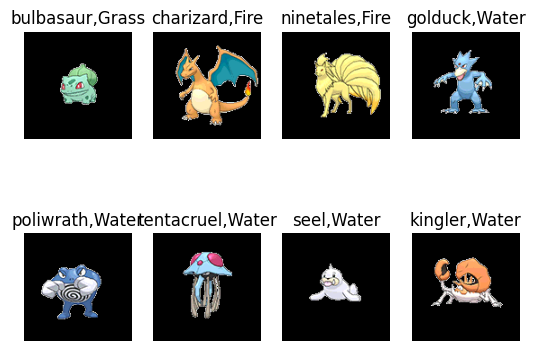

In [22]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(data.loc[i*5].img)
    plt.title(f"{data.loc[i*5].Name},{data.loc[i*5].Type1}")
    plt.axis('off')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
X=np.array(data['img'].tolist(), dtype = np.float32)/255.0
y=data['Type1']

In [25]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


augmented_images = []
augmented_labels = []


for i in range(len(X)):
    image = X[i]
    label = y[i]
    image = np.expand_dims(image, axis=0)
    label = np.array([label])
    augmented_images_batch, augmented_labels_batch = [], []
    j=0
    for x_batch, y_batch in datagen.flow(image, label, batch_size=4):
        augmented_images_batch.extend(x_batch)
        augmented_labels_batch.extend(y_batch)
        j+=1
        if j>3:
            break
    augmented_images.extend(augmented_images_batch)
    augmented_labels.extend(augmented_labels_batch)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [26]:
print(X.shape)
print(augmented_images.shape)

(218, 120, 120, 3)
(872, 120, 120, 3)


In [27]:
X=np.concatenate((X, augmented_images), axis=0)
y=np.concatenate((y,augmented_labels), axis=0)
print(X.shape)

(1090, 120, 120, 3)


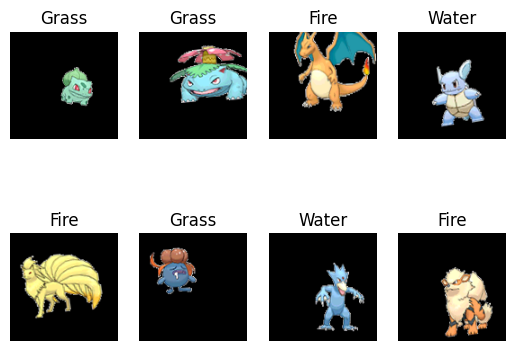

In [28]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(augmented_images[i*10])
    plt.title(f"{augmented_labels[i*10]}")
    plt.axis('off')
plt.show()

In [29]:
labels_dict={'Water': 0, 'Grass': 1, 'Fire': 2}


y_final = []
for yi in y:
    y_final.append(labels_dict[yi])


X_train, X_test, y_train, y_test=train_test_split(X,y_final, test_size=.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [30]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(120, 120, 3),kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [31]:
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 59, 59, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        

In [32]:
histor=cnn.fit(X_train, y_train, epochs=20, validation_data=(X_test,y_test))

Epoch 1/20



C:\python\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



28/28 [==============================] - 16s 347ms/step - loss: 2.0816 - accuracy: 0.4472 - val_loss: 1.7110 - val_accuracy: 0.4266
Epoch 2/20
28/28 [==============================] - 9s 306ms/step - loss: 1.3313 - accuracy: 0.6250 - val_loss: 1.1504 - val_accuracy: 0.6468
Epoch 3/20
28/28 [==============================] - 9s 306ms/step - loss: 1.0140 - accuracy: 0.6778 - val_loss: 0.9773 - val_accuracy: 0.7110
Epoch 4/20
28/28 [==============================] - 9s 304ms/step - loss: 0.8689 - accuracy: 0.6984 - val_loss: 1.0424 - val_accuracy: 0.5780
Epoch 5/20
28/28 [==============================] - 9s 319ms/step - loss: 0.7822 - accuracy: 0.7374 - val_loss: 0.7988 - val_accuracy: 0.6972
Epoch 6/20
28/28 [==============================] - 8s 300ms/step - loss: 0.6604 - accuracy: 0.8028 - val_loss: 1.0173 - val_accuracy: 0.5596
Epoch 7/20
28/28 [==============================] - 9s 310ms/step - loss: 0.6682 - accuracy: 0.7959 - val_loss: 0.6925 - val_accuracy: 0.7890
Epoch 8/20
28/2

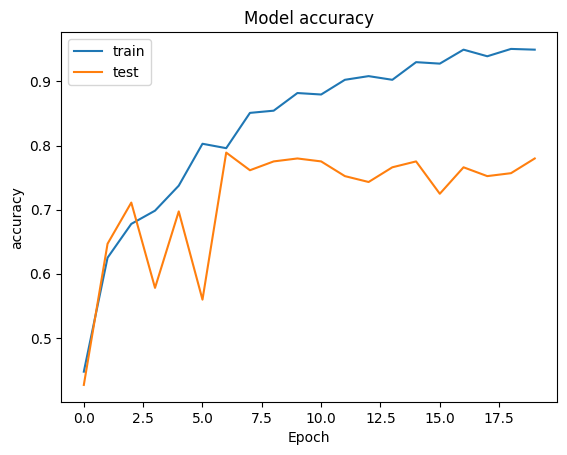

In [33]:
plt.plot(histor.history['accuracy'])
plt.plot(histor.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

In [34]:
y_pred=np.argmax(cnn.predict(X_test),axis=1)

7/7 [==============================] - 1s 58ms/step
